In [237]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import transform, draw, color, img_as_ubyte

In [352]:
def filter_similar_circles(cy, cx, radii, dist_thresh=10, radius_thresh=3):
    filtered_cx, filtered_cy, filtered_radii = [], [], []
    
    for i in range(len(cx)):
        keep_circle = True
        for j in range(len(filtered_cx)):
            # euclidean distance
            dist = np.sqrt((cx[i] - filtered_cx[j])**2 + (cy[i] - filtered_cy[j])**2)
            # compare radii
            rad_diff = np.abs(radii[i] - filtered_radii[j])
            
            if dist < dist_thresh and rad_diff < radius_thresh:
                keep_circle = False
                break
        
        if keep_circle:
            filtered_cx.append(cx[i])
            filtered_cy.append(cy[i])
            filtered_radii.append(radii[i])
    
    return np.array(filtered_cx), np.array(filtered_cy), np.array(filtered_radii)


In [250]:
headtool = Image.open('HeadTool0002.bmp')

# np array -> double precision
# headtool_gray = headtool.convert('L')
headtool_array = np.array(headtool)
headtool_double = headtool_array.astype(np.float64)/255.0

#  contrast-limited adaptive histogram equalization
headtool_scaled = (headtool_double * 255).astype(np.uint8)
clahe = cv2.createCLAHE(clipLimit=165.0, tileGridSize=(16, 16))
headtool_enhance = clahe.apply(headtool_scaled)
headtool_enhancedouble = headtool_enhance.astype(np.float64)/255.0

In [265]:
# canny edge detect
low_threshold = 200  # Lower threshold for edge detection
high_threshold = 650  # Upper threshold for edge detection
headtool_edges = cv2.Canny((headtool_enhance).astype(np.uint8), low_threshold, high_threshold)

In [385]:
# circle radii
radii = np.arange(20, 41)
# hough transform on edge detection
hough_res_edge = transform.hough_circle(headtool_edges, radii)
# find strongest circles
accumulated_accumulator_edge = np.sum(hough_res_edge, axis=0)
threshold_edge=0.049 * np.max(accumulated_accumulator_edge)
accum_edge, cx_edge, cy_edge, radius_edge = transform.hough_circle_peaks(hough_res_edge
                                                                         ,radii 
                                                        ,threshold=threshold_edge 
                                                         ,total_num_peaks=2
                                                     )
cx_edge_fill, cy_edge_fill, radius_edge_fill = filter_similar_circles(cy_edge, cx_edge, radius_edge)


In [386]:
# hough transform on CLAHE
hough_res_clahe = transform.hough_circle(headtool_enhancedouble, radii)
# find strongest circles
accumulated_accumulator_clahe = np.sum(hough_res_clahe, axis=0)
threshold_clahe=0.045 * np.max(accumulated_accumulator_clahe)
accum_clahe, cx_clahe, cy_clahe, radius_clahe = transform.hough_circle_peaks(hough_res_clahe
    ,radii 
    ,threshold=threshold_clahe 
     ,total_num_peaks=2
    )
cx_clahe_fill, cy_clahe_fill, radius_clahe_fill = filter_similar_circles(cy_clahe, cx_clahe, radius_clahe)


In [367]:
print(f"x:{cx_clahe}\n"
      f"y:{cy_clahe}\n"
      f"rads:{radius_clahe}")

x:[ 820  734  169 ... 1223  177  406]
y:[400 920 923 ... 491 885 130]
rads:[30 30 30 ... 30 30 25]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


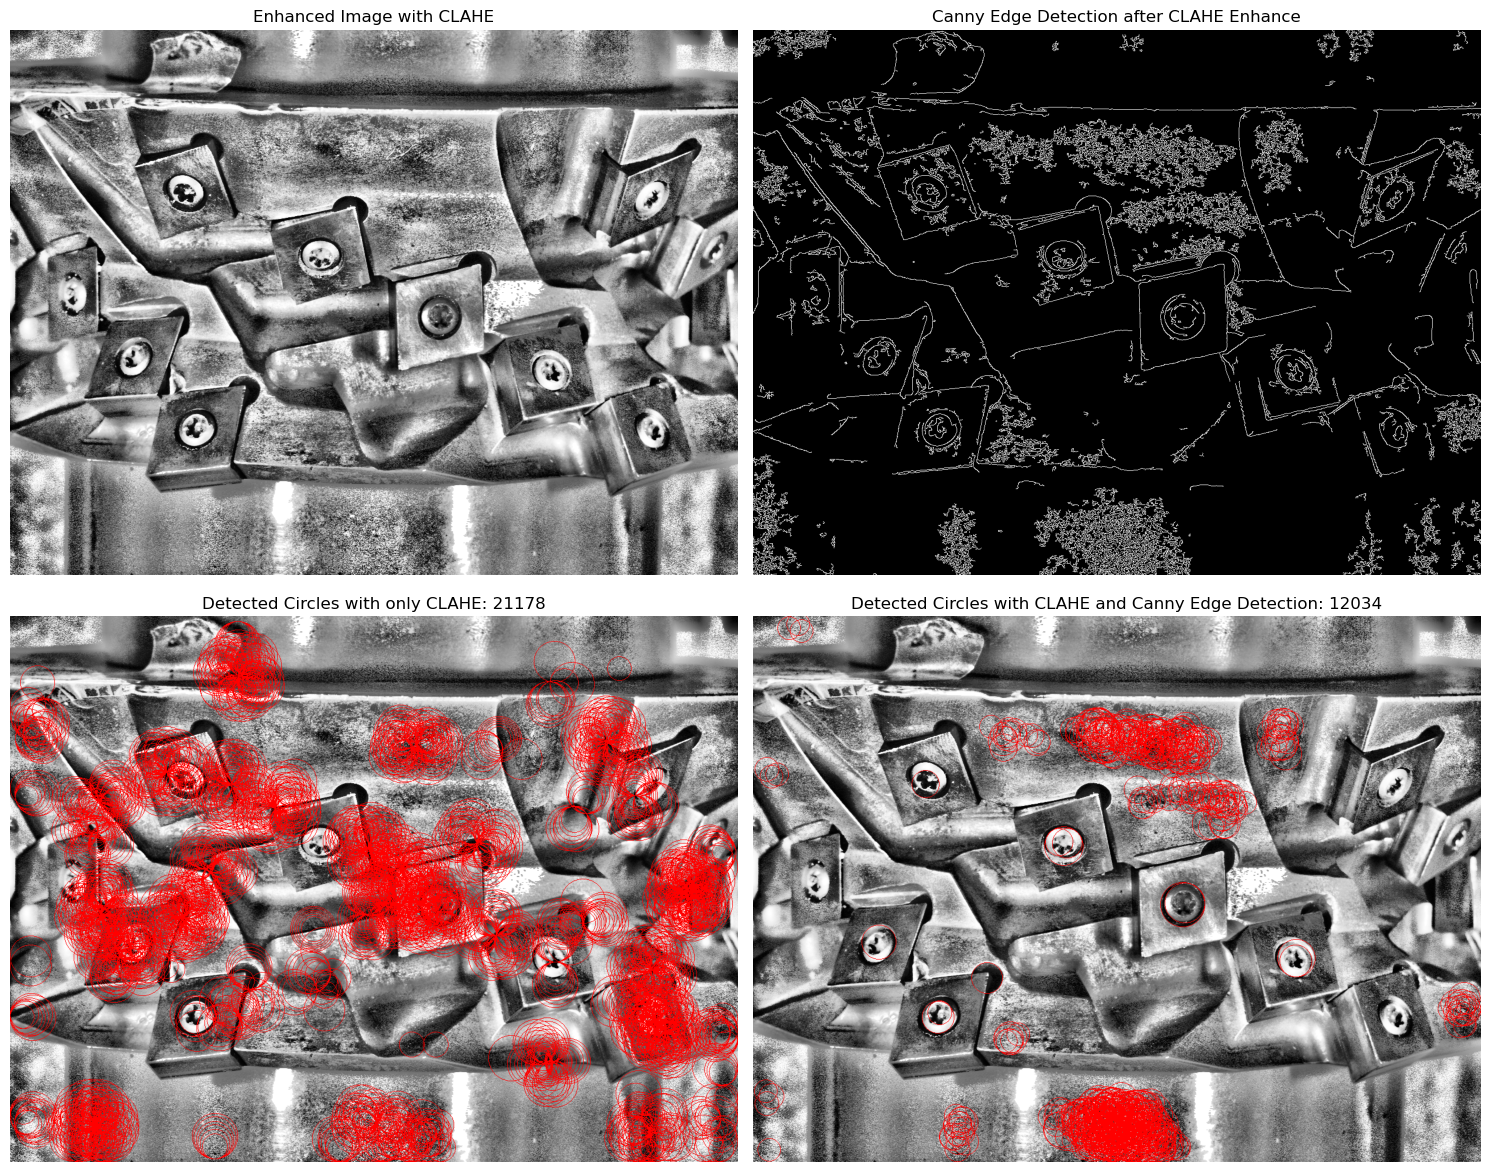

In [381]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
# show image: enhanced double
# Plot the enhanced image
ax[0][0].imshow(headtool_enhancedouble, cmap="gray")
ax[0][0].set_title('Enhanced Image with CLAHE')
ax[0][0].axis('off')

# show canny edges
ax[0][1].imshow(headtool_edges, cmap="gray")
ax[0][1].set_title('Canny Edge Detection after CLAHE Enhance')
ax[0][1].axis('off')

image_with_circles_edge = color.gray2rgb(headtool_enhancedouble)
# Draw the circles on the copy of the enhanced image
for center_y, center_x, rad in zip(cy_edge_fill, cx_edge_fill, radius_edge_fill):
    circy, circx = draw.circle_perimeter(center_y, center_x, rad, shape=image_with_circles_edge.shape)
    image_with_circles_edge[circy, circx] = (255, 0, 0)
    
ax[1][1].imshow(image_with_circles_edge)
ax[1][1].set_title(f'Detected Circles with CLAHE and Canny Edge Detection: {len(radius_edge)}')
ax[1][1].axis('off')

image_with_circles_clahe = color.gray2rgb(headtool_enhancedouble)
# Draw the circles on the copy of the enhanced image
for center_y, center_x, rad in zip(cy_clahe_fill, cx_clahe_fill, radius_clahe_fill):
    circy, circx = draw.circle_perimeter(center_y, center_x, rad, shape=image_with_circles_clahe.shape)
    image_with_circles_clahe[circy, circx] = (255, 0, 0)
ax[1][0].imshow(image_with_circles_clahe)
ax[1][0].set_title(f'Detected Circles with only CLAHE: {len(radius_clahe)}')
ax[1][0].axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


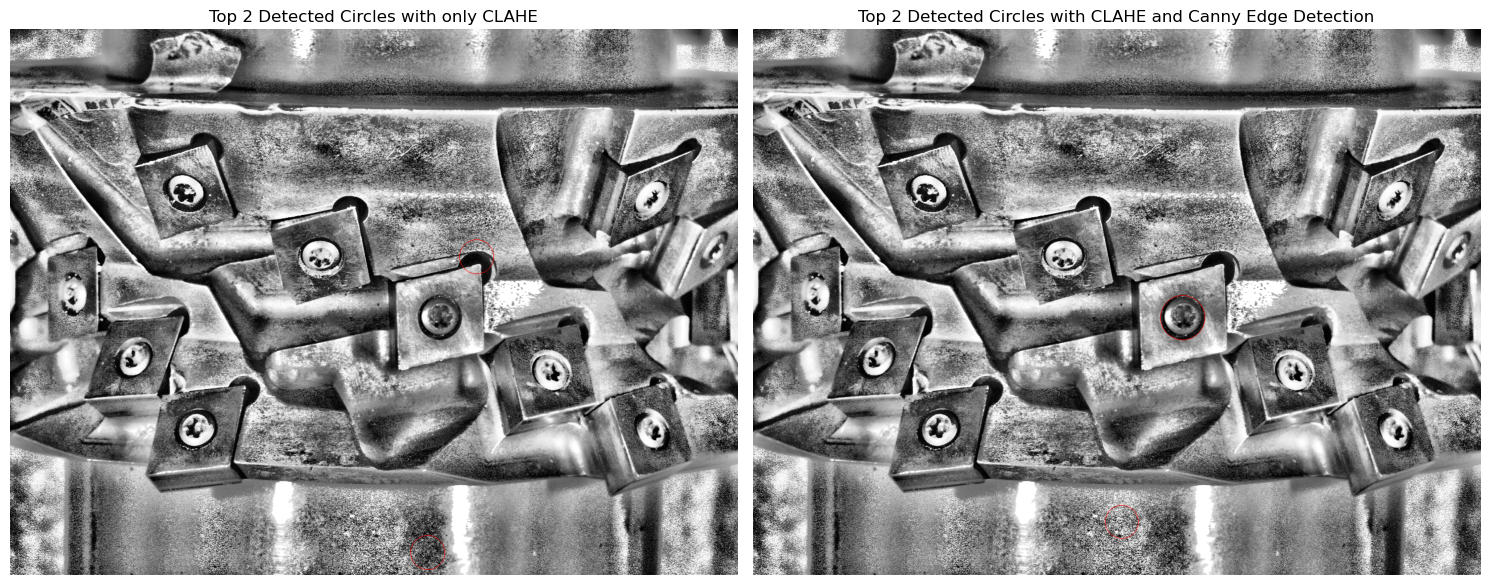

In [387]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
image_with_circles_edge = color.gray2rgb(headtool_enhancedouble)
# Draw the circles on the copy of the enhanced image
for center_y, center_x, rad in zip(cy_edge, cx_edge, radius_edge):
    circy, circx = draw.circle_perimeter(center_y, center_x, rad, shape=image_with_circles_edge.shape)
    image_with_circles_edge[circy, circx] = (255, 0, 0)
    
ax[1].imshow(image_with_circles_edge)
ax[1].set_title(f'Top 2 Detected Circles with CLAHE and Canny Edge Detection')
ax[1].axis('off')

image_with_circles_clahe = color.gray2rgb(headtool_enhancedouble)
# Draw the circles on the copy of the enhanced image
for center_y, center_x, rad in zip(cy_clahe, cx_clahe, radius_clahe):
    circy, circx = draw.circle_perimeter(center_y, center_x, rad, shape=image_with_circles_clahe.shape)
    image_with_circles_clahe[circy, circx] = (255, 0, 0)
ax[0].imshow(image_with_circles_clahe)
ax[0].set_title(f'Top 2 Detected Circles with only CLAHE')
ax[0].axis('off')

plt.tight_layout()
plt.show()

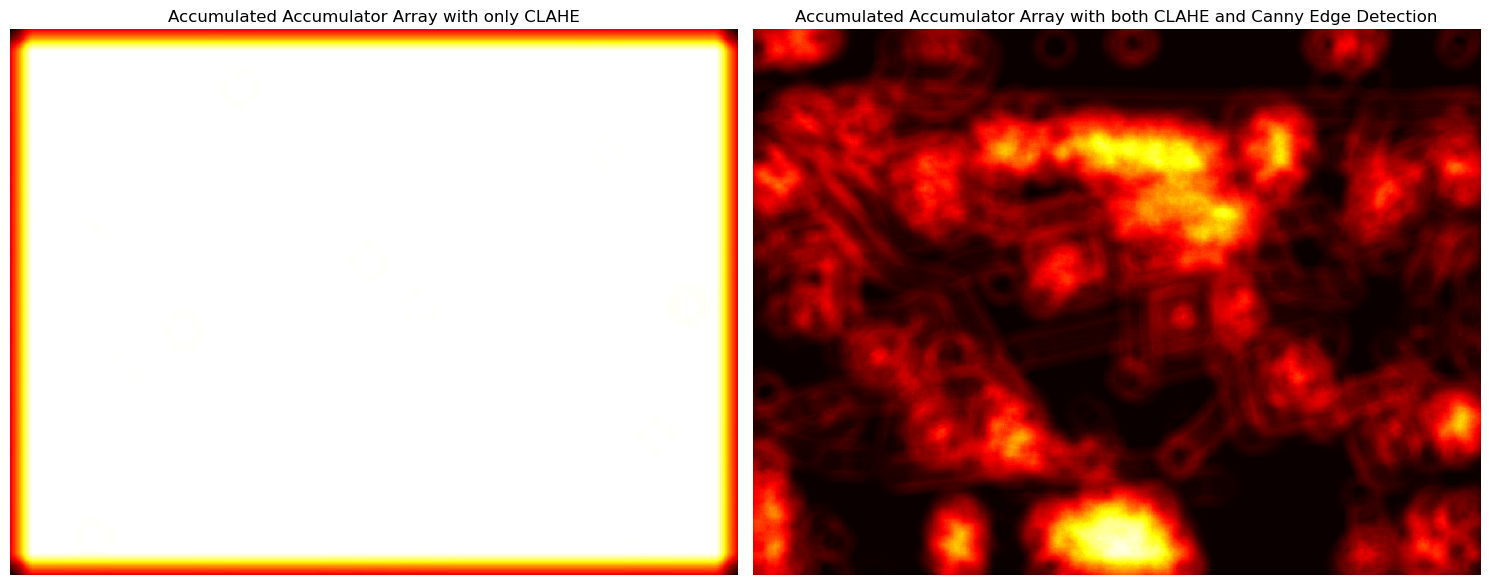

In [388]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
image_with_circles_edge = color.gray2rgb(headtool_enhancedouble)

ax[1].imshow(accumulated_accumulator_edge, cmap='hot', interpolation='nearest')
ax[1].set_title(f'Accumulated Accumulator Array with both CLAHE and Canny Edge Detection')
ax[1].axis('off')


ax[0].imshow(accumulated_accumulator_clahe, cmap='hot', interpolation='nearest')
ax[0].set_title(f'Accumulated Accumulator Array with only CLAHE')
ax[0].axis('off')

plt.tight_layout()
plt.show()